In [32]:
import sys

sys.path.append("../")

from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [33]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss


# 1. Load data, prep & train test split

In [36]:
df = pd.read_csv("../datasets/churn/fin_churn.csv" )
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
RAW_DATA_PATH = "../datasets/churn/fin_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem

In [35]:
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [37]:
df.exited.value_counts()/df.shape[0]*100

exited
0    79.63
1    20.37
Name: count, dtype: float64

In [38]:
70.63/20.37

3.467353951890034

In [39]:
20.37/70.63

0.28840436075322107

In [8]:
df.isna().any()

row_number          False
customer_id         False
surname             False
credit_score        False
geography           False
gender              False
age                 False
tenure              False
balance             False
num_of_products     False
has_cr_card         False
is_active_member    False
estimated_salary    False
exited              False
dtype: bool

In [40]:
y = "exited"

# some generic cleaning

COLUMNS_TO_DROP = ["customer_id", "surname"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [10]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 192 candidates, totalling 960 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^

Best score: 0.7721610116439214
Best parameters: {'logistic__C': 1000, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 12, 'under__sampling_strategy': 0.5}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['geography', 'gender'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=12)),
                ('logistic', LogisticRegression(C=1000))])

In [11]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

Op de k-de fold als test set over alle k-folds de mean van test-metric = "roc_auc"

In [12]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.3,0.5,6,1,l2,0.706445,0.014215
48,0.3,0.5,6,10,l2,0.699853,0.016299
96,0.3,0.5,6,100,l2,0.680336,0.023082
144,0.3,0.5,6,1000,l2,0.699674,0.021359
4,0.3,0.5,8,1,l2,0.754438,0.006945
...,...,...,...,...,...,...,...
186,0.7,1.0,10,1000,l2,0.766715,0.006642
46,0.7,1.0,12,1,l2,0.770740,0.006712
94,0.7,1.0,12,10,l2,0.771497,0.007076
142,0.7,1.0,12,100,l2,0.770412,0.007440


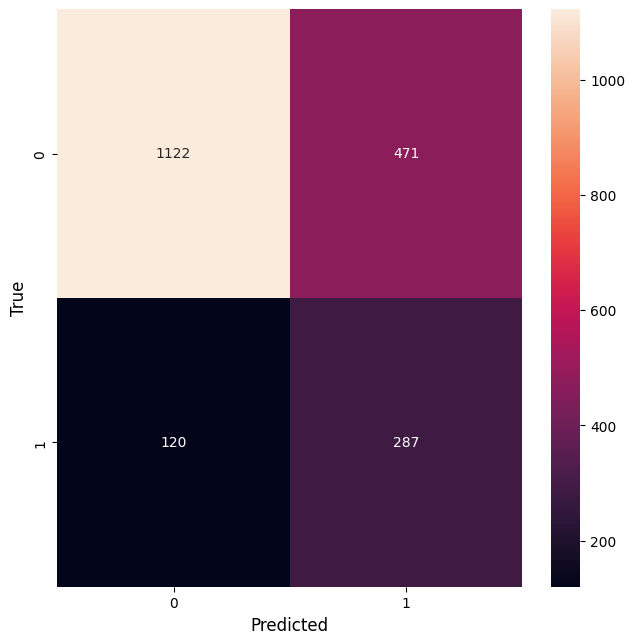

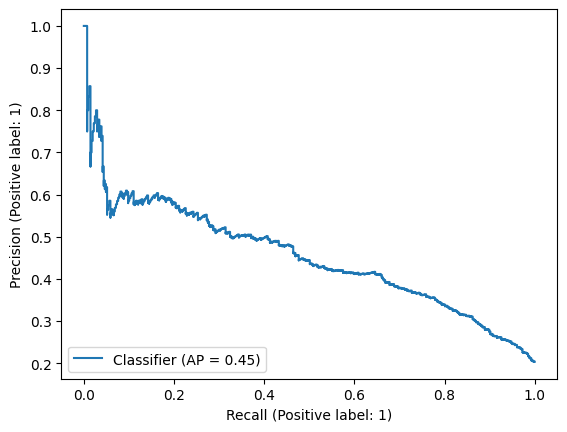

In [13]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [41]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [43]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [14, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized= True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.8349202068746328
Best parameters: {'xgb__subsample': 0.8, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.6, 'under__sampling_strategy': 0.5, 'pca__n_components': 14, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strate...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [ ]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

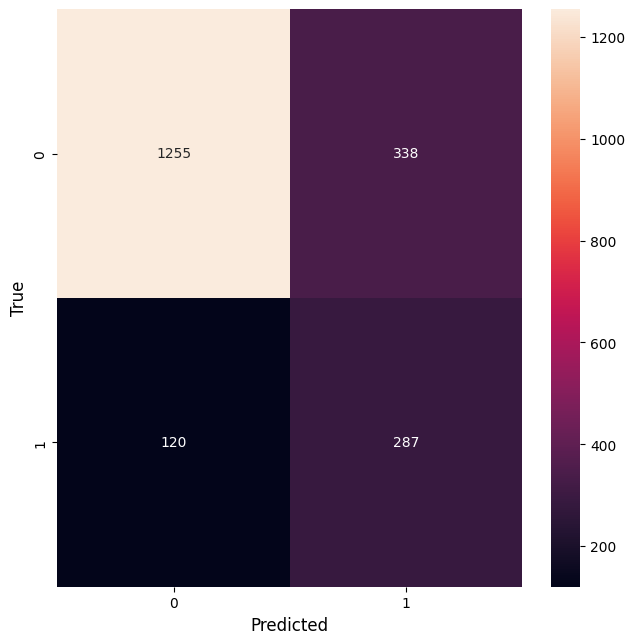

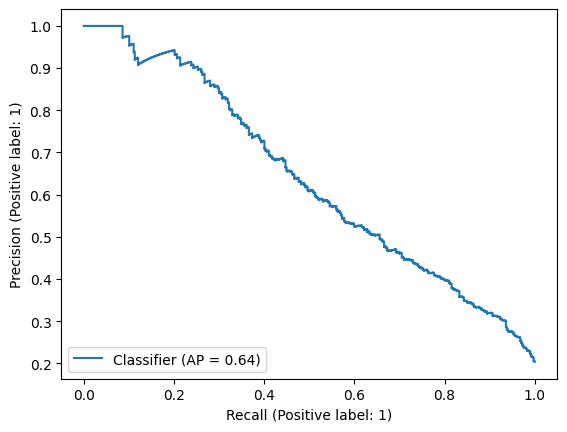

In [61]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [42]:
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

FileNotFoundError: [Errno 2] No such file or directory: '../models/fin_churn/xgb.pkl'

# cost evaluation metrics

In [44]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    """
    Calculates the instance-dependent cost for a single instance.

    Parameters
    ----------
    prediction : int
        The predicted label.
    encoded_true_label : int
        The true label.
    a : float
        The cost of a false positive.

    Returns
    -------
    float
        The instance-dependent cost.
    """
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 * a
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a

test_predictions = test.copy(deep=True)
test_predictions["y_predicted"] = best_pipeline_log_reg.predict(test_predictions.drop(y, axis=1))
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions['A'] = impute.fit_transform(
    (test_predictions["balance"]*test_predictions["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions['A'] = scaler.fit_transform(test_predictions['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions['instance_cost'] = test_predictions.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions['instance_cost'].sum()/len(test_predictions))

Test cost/loss = 737.
 total cost/loss average :  0.36848865840769207


In [45]:
def instance_dependent_cost(prediction: int, encoded_true_label: int, a: float) -> float:
    """
    Calculates the instance-dependent cost for a single instance.

    Parameters
    ----------
    prediction : int
        The predicted label.
    encoded_true_label : int
        The true label.
    a : float
        The cost of a false positive.

    Returns
    -------
    float
        The instance-dependent cost.
    """
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 0
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 2 * a
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return 12 * a

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["balance"]*test_predictions_xgb["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 702.
 total cost/loss average :  0.3508256094959738


In [46]:
print(test_predictions[['exited', "A", 'instance_cost', 'y_predicted']].iloc[56:80])
print(test[y])

      exited         A  instance_cost  y_predicted
2971       0  0.432032       0.000000            0
3115       0  0.000000       0.000000            0
6475       1  0.228594       0.000000            1
5092       1  0.000000       0.000000            1
6242       0  0.385771       0.771542            1
3435       0  0.345260       0.000000            0
7334       0  0.000000       0.000000            0
7734       0  0.000000       0.000000            0
4570       0  0.525561       1.051121            1
7780       0  0.328031       0.000000            0
9797       0  0.000000       0.000000            0
564        0  0.476171       0.000000            0
7029       1  0.000000       0.000000            1
4268       1  0.000000       0.000000            0
7120       0  0.666320       0.000000            0
838        1  0.000000       0.000000            1
8544       0  0.204663       0.000000            0
8457       0  0.000000       0.000000            0
3022       0  0.000000       0.

# AMC metric

Decision Threshold: 0.01, Test cost/loss = 836.28
Decision Threshold: 0.02, Test cost/loss = 836.28
Decision Threshold: 0.03, Test cost/loss = 836.28
Decision Threshold: 0.04, Test cost/loss = 836.28
Decision Threshold: 0.05, Test cost/loss = 836.28
Decision Threshold: 0.06, Test cost/loss = 833.46
Decision Threshold: 0.07, Test cost/loss = 831.63
Decision Threshold: 0.08, Test cost/loss = 831.22
Decision Threshold: 0.09, Test cost/loss = 830.20
Decision Threshold: 0.10, Test cost/loss = 826.54
Decision Threshold: 0.11, Test cost/loss = 819.86
Decision Threshold: 0.12, Test cost/loss = 817.49
Decision Threshold: 0.13, Test cost/loss = 812.52
Decision Threshold: 0.14, Test cost/loss = 806.12
Decision Threshold: 0.15, Test cost/loss = 800.20
Decision Threshold: 0.16, Test cost/loss = 800.29
Decision Threshold: 0.17, Test cost/loss = 798.93
Decision Threshold: 0.18, Test cost/loss = 788.12
Decision Threshold: 0.19, Test cost/loss = 781.36
Decision Threshold: 0.20, Test cost/loss = 769.80


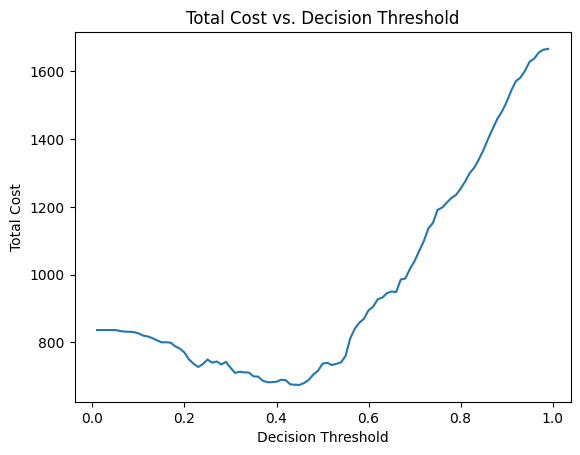

(0.45, 0.33712601050241364, 674.2520210048273)

In [55]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')

Decision Threshold: 0.01, Test cost/loss = 835.33
Decision Threshold: 0.02, Test cost/loss = 829.06
Decision Threshold: 0.03, Test cost/loss = 822.12
Decision Threshold: 0.04, Test cost/loss = 815.17
Decision Threshold: 0.05, Test cost/loss = 813.96
Decision Threshold: 0.06, Test cost/loss = 811.25
Decision Threshold: 0.07, Test cost/loss = 794.87
Decision Threshold: 0.08, Test cost/loss = 788.10
Decision Threshold: 0.09, Test cost/loss = 772.36
Decision Threshold: 0.10, Test cost/loss = 771.88
Decision Threshold: 0.11, Test cost/loss = 758.70
Decision Threshold: 0.12, Test cost/loss = 748.81
Decision Threshold: 0.13, Test cost/loss = 751.34
Decision Threshold: 0.14, Test cost/loss = 742.36
Decision Threshold: 0.15, Test cost/loss = 733.68
Decision Threshold: 0.16, Test cost/loss = 715.79
Decision Threshold: 0.17, Test cost/loss = 705.56
Decision Threshold: 0.18, Test cost/loss = 704.99
Decision Threshold: 0.19, Test cost/loss = 695.63
Decision Threshold: 0.20, Test cost/loss = 693.06


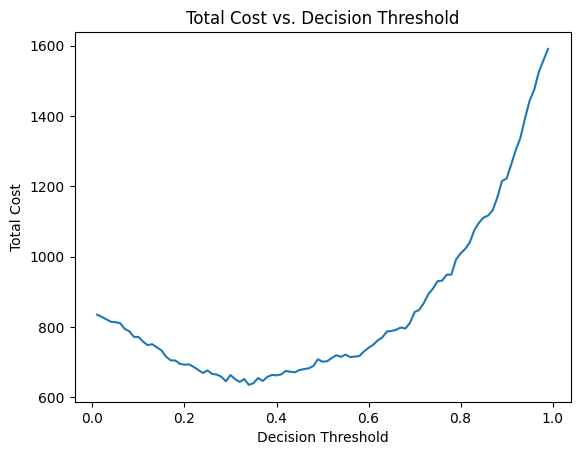

(0.34, 0.31781511028728987, 635.6302205745798)

In [56]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, Lowest Test cost/loss = {lowest_cost:.2f}, Lowest AMC = {AMC:.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_xgb, y, 'cb')

# E-AMC metric

In [52]:
cb_column = 'cb'
test[cb_column]= (test["balance"]*test["credit_score"])
(test["balance"]*test["credit_score"])
caler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test[cb_column] = scaler.fit_transform(test[cb_column].values.reshape(-1, 1))
test['TN'] = 0
test['FN'] = 12* test[cb_column]
test['FP'] = 2* test[cb_column] 
test['TP'] = 0 

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)

test_predictions_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP']= test_actual_label_0['prob_churn']*test_actual_label_0['FP']+(1-test_actual_label_0['prob_churn'])*test_actual_label_0['TN']
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [49]:
test

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,...,exited,y_predicted_proba,cb,TN,FN,FP,TP,prob_churn,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,...,0,0.282247,0.601333,0,7.215993,1.202666,0,0.570303,0.339449,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,...,0,0.660493,0.000000,0,0.000000,0.000000,0,0.062803,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,...,0,0.339921,0.000000,0,0.000000,0.000000,0,0.050456,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,...,0,0.340652,0.354861,0,4.258328,0.709721,0,0.100595,0.241768,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,...,0,0.348340,0.427838,0,5.134061,0.855677,0,0.234776,0.298066,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,...,1,0.566360,0.000000,0,0.000000,0.000000,0,0.619269,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,...,1,0.267194,0.705345,0,8.464146,1.410691,0,0.359547,6.202575,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,...,1,0.580188,0.000000,0,0.000000,0.000000,0,0.694667,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,...,1,0.636054,0.379735,0,4.556821,0.759470,0,0.877860,1.658435,3.628369


In [53]:
print(test['EAP'].sum())
print(test['EP'].sum())


print('EAP : ', test['EAP'].sum()/len(test))
print('EP : ', test['EP'].sum()/len(test))

967.2397545662297
1497.296708062372
EAP :  0.4836198772831149
EP :  0.748648354031186


In [54]:
print(test_xgb['EAP'].sum())
print(test_xgb['EP'].sum())


print('EAP : ', test_xgb['EAP'].sum()/len(test))
print('EP : ', test_xgb['EP'].sum()/len(test))

850.5925638419982
1497.296708062372
EAP :  0.4252962819209991
EP :  0.748648354031186


# emp and mp

In [57]:
test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["exited"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions['y_predicted_proba'], test_predictions["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1


In [58]:
test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["exited"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


output(MP=4.630310999999999, MP_fraction=0.44599999999999995, EMP=4.769420409828738, EMP_fraction=0.4094177064669194)

In [59]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions_xgb['y_predicted_proba'], test_predictions_xgb["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1


In [60]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)

C:\Users\stijn\AppData\Local\Temp\ipykernel_30348\2700567008.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=5.34589, MP_fraction=0.4165, EMP=5.479700690875042, EMP_fraction=0.3621962017278799)